In [1]:
import os
import numpy as np
import tensorflow as tf
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1) Load TIF
# ---------------------------
def load_tif(path):
    with rasterio.open(path) as src:
        img = src.read()
        img = np.transpose(img, (1, 2, 0))
        img = img.astype("float32") / 10000.0
    return img

# ---------------------------
# 2) Paths + Labels
# ---------------------------
base_dir = r"C:\DEPI Project\EuroSATallBands"
classes = sorted(os.listdir(base_dir))
class_to_idx = {cls: i for i, cls in enumerate(classes)}

filepaths, labels = [], []
for cls in classes:
    cls_dir = os.path.join(base_dir, cls)
    for f in os.listdir(cls_dir):
        if f.endswith(".tif"):
            filepaths.append(os.path.join(cls_dir, f))
            labels.append(class_to_idx[cls])

# ---------------------------
# 3) Split
# ---------------------------
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    filepaths, labels, test_size=0.3, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42)

# ---------------------------
# 4) Data Generator
# ---------------------------
class MultiSpectralGenerator(tf.keras.utils.Sequence):
    def __init__(self, paths, labels, batch_size=32, shuffle=True):
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.paths) // self.batch_size

    def __getitem__(self, idx):
        batch_paths = self.paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]

        images = [load_tif(p) for p in batch_paths]
        return np.array(images), tf.keras.utils.to_categorical(batch_labels, num_classes)

    def on_epoch_end(self):
        if self.shuffle:
            c = list(zip(self.paths, self.labels))
            np.random.shuffle(c)
            self.paths, self.labels = zip(*c)

num_classes = len(classes)

train_gen = MultiSpectralGenerator(train_paths, train_labels)
val_gen   = MultiSpectralGenerator(val_paths, val_labels)
test_gen  = MultiSpectralGenerator(test_paths, test_labels, shuffle=False)


In [2]:
def build_simple_cnn(input_shape=(64,64,13), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model


In [3]:
def build_improved_cnn(input_shape=(64,64,13), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation="relu"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model


In [4]:
def build_advanced_cnn(input_shape=(64,64,13), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.GlobalAveragePooling2D(),

        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model


In [16]:
def train_model(model, name):
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5)
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,
        callbacks=callbacks
    )

    model.save(f"{name}.h5")
    return model, history


In [12]:
def evaluate_model(model):
    preds = model.predict(test_gen)
    preds_labels = np.argmax(preds, axis=1)
    true_labels = test_labels[:len(preds_labels)]

    print("\nClassification Report:")
    print(classification_report(true_labels, preds_labels, target_names=classes))

    cm = confusion_matrix(true_labels, preds_labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()


In [13]:
import random

def random_search(trials=5):
    for i in range(trials):
        filters = random.choice([32, 64, 128])
        dense = random.choice([128, 256, 512])
        dropout = random.choice([0.3, 0.4, 0.5])

        print(f"\nTrial {i+1}")
        print(f"filters={filters}, dense={dense}, dropout={dropout}")

        model = models.Sequential([
            layers.Conv2D(filters, 3, padding="same", activation="relu", input_shape=(64,64,13)),
            layers.MaxPooling2D(),
            layers.Conv2D(filters*2, 3, padding="same", activation="relu"),
            layers.GlobalAveragePooling2D(),
            layers.Dense(dense, activation="relu"),
            layers.Dropout(dropout),
            layers.Dense(num_classes, activation="softmax")
        ])

        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

        model.fit(train_gen, validation_data=val_gen, epochs=10)
        model.evaluate(test_gen)



====== TRAINING SIMPLE CNN ======
Epoch 1/30
603/603 [==============================] - 430s 711ms/step - loss: 0.9354 - accuracy: 0.6604 - val_loss: 0.6310 - val_accuracy: 0.7779 - lr: 0.0010
Epoch 2/30
603/603 [==============================] - 438s 727ms/step - loss: 0.5888 - accuracy: 0.7925 - val_loss: 0.4454 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 3/30
603/603 [==============================] - 363s 601ms/step - loss: 0.4447 - accuracy: 0.8446 - val_loss: 0.4375 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 4/30
603/603 [==============================] - 366s 607ms/step - loss: 0.3631 - accuracy: 0.8705 - val_loss: 0.3867 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 5/30
603/603 [==============================] - 359s 596ms/step - loss: 0.3098 - accuracy: 0.8907 - val_loss: 0.3028 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 6/30
603/603 [==============================] - 365s 605ms/step - loss: 0.2763 - accuracy: 0.9013 - val_loss: 0.3896 - val_accuracy: 0.8685 - lr: 0.0010
Epoch 7/30


C:\Users\Cyber\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 93s 720ms/step

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.88      0.89      0.89       446
              Forest       0.97      0.98      0.97       453
HerbaceousVegetation       0.89      0.87      0.88       474
             Highway       0.85      0.83      0.84       407
          Industrial       0.94      0.92      0.93       358
             Pasture       0.89      0.81      0.85       315
       PermanentCrop       0.86      0.80      0.83       361
         Residential       0.82      0.95      0.88       452
               River       0.97      0.96      0.96       357
             SeaLake       1.00      0.99      1.00       505

            accuracy                           0.91      4128
           macro avg       0.91      0.90      0.90      4128
        weighted avg       0.91      0.91      0.91      4128



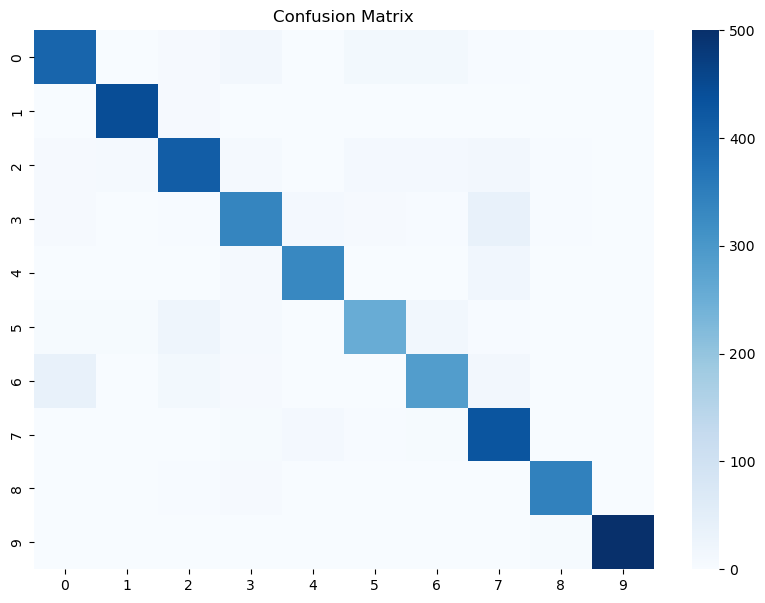

In [17]:
# ===============================
# 1) SIMPLE CNN
# ===============================
print("\n====== TRAINING SIMPLE CNN ======")
simple_model = build_simple_cnn(input_shape=(64,64,13), num_classes=num_classes)
simple_model, hist_simple = train_model(simple_model, "model_v1_Simple_CNN")

print("\n====== EVALUATING SIMPLE CNN ======")
evaluate_model(simple_model)




In [ ]:
# ===============================
# 2) IMPROVED CNN
# ===============================
print("\n====== TRAINING IMPROVED CNN ======")
improved_model = build_improved_cnn(input_shape=(64,64,13), num_classes=num_classes)
improved_model, hist_improved = train_model(improved_model, "model_v2_Improved_CNN")

print("\n====== EVALUATING IMPROVED CNN ======")
evaluate_model(improved_model)


====== TRAINING IMPROVED CNN ======
Epoch 1/30
603/603 [==============================] - 405s 669ms/step - loss: 0.9893 - accuracy: 0.6357 - val_loss: 0.6019 - val_accuracy: 0.7740 - lr: 0.0010
Epoch 2/30
603/603 [==============================] - 488s 809ms/step - loss: 0.5842 - accuracy: 0.7956 - val_loss: 0.4351 - val_accuracy: 0.8355 - lr: 0.0010
Epoch 3/30
 97/603 [===>..........................] - ETA: 4:38 - loss: 0.4627 - accuracy: 0.8399

In [ ]:
# ===============================
# 3) ADVANCED CNN
# ===============================
print("\n====== TRAINING ADVANCED CNN ======")
advanced_model = build_advanced_cnn(input_shape=(64,64,13), num_classes=num_classes)
advanced_model, hist_advanced = train_model(advanced_model, "model_v3_Advanced_CNN")

print("\n====== EVALUATING ADVANCED CNN ======")
evaluate_model(advanced_model)

